# VR CO2 Study - Data processing

This notebook does the following:

1. x
2. y
3. z

Input: input
Output: output

In [2]:
import pandas as pd
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.Tests import Tests
from utils.Plots import Plots
import statsmodels.formula.api as smf

In [3]:
# Create new directory for notebook output
notebook_temp_dir = os.path.join(os.getcwd(), "temp", "3_statistics")

if not os.path.exists(notebook_temp_dir):
    os.makedirs(notebook_temp_dir)

In [4]:
# File containing features for entire segments
segment_features_file = 'D:\\co2-study\\temp\\segment_features.csv'
segment_features = pd.read_csv(segment_features_file, index_col=0)

# File containing features for windows of data
windowed_features_file = 'D:\\co2-study\\temp\\windowed_features.csv'
windowed_features = pd.read_csv(windowed_features_file, index_col=0)

In [5]:
# Filter the data for 'air' and 'co2' conditions with 'gas_inhalation' segment
gas_inhalation_segments = segment_features[(segment_features['Condition'].isin(['AIR', 'CO2'])) & (segment_features['Segment'] == 'gas_inhalation')]
gas_inhalation_windows = windowed_features[(windowed_features['Condition'].isin(['AIR', 'CO2'])) & (windowed_features['Segment'] == 'gas_inhalation')]
gas_inhalation_segments = gas_inhalation_segments.dropna()
gas_inhalation_windows = gas_inhalation_windows.dropna()


# Calculate mean combined pupil size using left and right pupils
gas_inhalation_segments['pupil_size_combined'] = (gas_inhalation_segments['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2
gas_inhalation_windows['pupil_size_combined'] = (gas_inhalation_windows['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_windows['VerboseData.Right.PupilDiameterMm_mean']) / 2

# add window index for each participant/condition
window_index = pd.DataFrame({'window_index': gas_inhalation_windows.groupby(['participant_number', 'Condition']).cumcount()})
gas_inhalation_windows.insert(3, 'window_index', window_index['window_index'])

# GSR


In [6]:
# Filter GSR data for segmented and windowed data
gsr_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Biopac_GSR_)').reset_index(drop=True)
gsr_air_segments = gsr_data_segments[gsr_data_segments['Condition']=='AIR']
gsr_co2_segments = gsr_data_segments[gsr_data_segments['Condition']=='CO2']

gsr_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_GSR_)').reset_index(drop=True)
gsr_air_windows = gsr_data_windows[gsr_data_windows['Condition']=='AIR']
gsr_co2_windows = gsr_data_windows[gsr_data_windows['Condition']=='CO2']

In [7]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(gsr_air_segments['Biopac_GSR_mean'], 'AIR')
Tests.normality_test_sw(gsr_co2_segments['Biopac_GSR_mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9097617268562317
Shapiro-Wilk Test - p-value: 0.0017018801299855113
Data for AIR condition is NOT normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9044846892356873
Shapiro-Wilk Test - p-value: 0.0011468266602605581
Data for CO2 condition is NOT normally distributed.


ShapiroResult(statistic=0.9044846892356873, pvalue=0.0011468266602605581)

In [8]:
# 
Tests.paired_t_test(gsr_air_segments['Biopac_GSR_mean'],gsr_co2_segments['Biopac_GSR_mean'])

T-statistic: -8.538
P-value: 0.000
SIGNIFICANT difference found.


(-8.538469607064895, 5.748323645578251e-11)

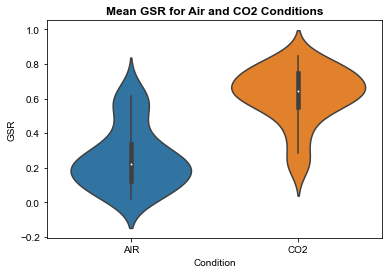

In [9]:
Plots.segment_violin(gsr_data_segments, 'Biopac_GSR_mean', 'Mean GSR for Air and CO2 Conditions', 'Condition', 'GSR', 
                    notebook_temp_dir)

In [10]:
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(gsr_air_windows, gsr_co2_windows, gsr_data_windows, 'Biopac_GSR_mean', 2)

Running mixed polynomial regression model independently for air and co2 conditions for: Biopac_GSR_mean
AIR MODEL
                Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Biopac_GSR_mean
No. Observations:     5151      Method:               REML           
No. Groups:           46        Scale:                0.0098         
Min. group size:      49        Log-Likelihood:       4438.5998      
Max. group size:      115       Converged:            Yes            
Mean group size:      112.0                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  0.312    0.026  11.823 0.000  0.260  0.364
window_index              -0.003    0.000 -20.145 0.000 -0.004 -0.003
np.power(window_index, 2)  0.000    0.000  21.415 0.000  0.000

C:\Users\m\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


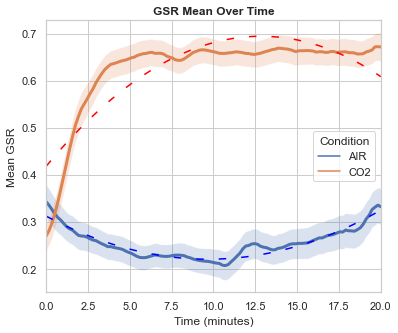

In [11]:
Plots.features_time_series(gas_inhalation_windows, 'Biopac_GSR_mean', 'GSR Mean Over Time', 'Time (minutes)', 'Mean GSR', 
                          os.path.join(notebook_temp_dir, "GSR_mean_over_time"), air_prediction_line, co2_prediction_line)

# RSP


In [12]:
# RSP
rsp_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_RSP_|RSP_)').reset_index(drop=True)
rsp_air_segments = rsp_data_segments[rsp_data_segments['Condition']=='AIR']
rsp_co2_segments = rsp_data_segments[rsp_data_segments['Condition']=='CO2']

rsp_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Biopac_RSP_|RSP_)').reset_index(drop=True)
rsp_air_windows = rsp_data_windows[rsp_data_windows['Condition']=='AIR']
rsp_co2_windows = rsp_data_windows[rsp_data_windows['Condition']=='CO2']

In [13]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(rsp_air_segments['RSP_Rate_Mean'], 'AIR')
Tests.normality_test_sw(rsp_co2_segments['RSP_Rate_Mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9675655364990234
Shapiro-Wilk Test - p-value: 0.22444088757038116
Data for AIR condition is  normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9650021195411682
Shapiro-Wilk Test - p-value: 0.1791263073682785
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.9650021195411682, pvalue=0.1791263073682785)

In [14]:
Tests.paired_t_test(rsp_air_segments['RSP_Rate_Mean'],rsp_co2_segments['RSP_Rate_Mean'])

T-statistic: -14.216
P-value: 0.000
SIGNIFICANT difference found.


(-14.21639544143445, 2.9644907837639765e-18)

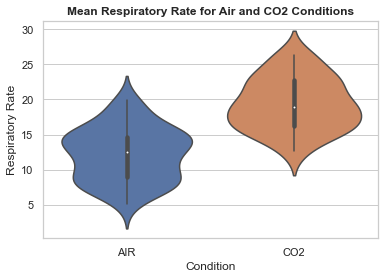

In [15]:
Plots.segment_violin(rsp_data_segments, 'RSP_Rate_Mean', 'Mean Respiratory Rate for Air and CO2 Conditions', 'Condition', 'Respiratory Rate', 
                    notebook_temp_dir)

In [16]:
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(rsp_air_windows, rsp_co2_windows, rsp_data_windows, 'RSP_Rate_Mean', 2)

Running mixed polynomial regression model independently for air and co2 conditions for: RSP_Rate_Mean
AIR MODEL
               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    RSP_Rate_Mean
No. Observations:    5151       Method:                REML         
No. Groups:          46         Scale:                 2.7137       
Min. group size:     49         Log-Likelihood:        -10040.0356  
Max. group size:     115        Converged:             Yes          
Mean group size:     112.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 12.015    0.551 21.796 0.000 10.934 13.095
window_index               0.008    0.003  2.814 0.005  0.002  0.013
np.power(window_index, 2)  0.000    0.000  0.318 0.751 -0.000  0.000
Group V

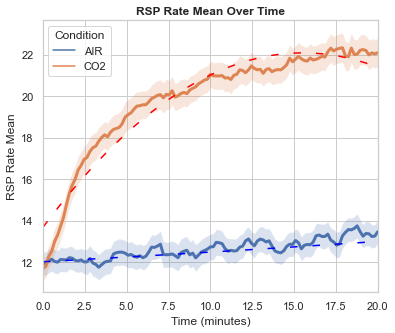

In [17]:
Plots.features_time_series(gas_inhalation_windows, 'RSP_Rate_Mean', 'RSP Rate Mean Over Time', 'Time (minutes)', 'RSP Rate Mean', os.path.join(notebook_temp_dir, "RSP_mean_over_time"), air_prediction_line, co2_prediction_line)

# HR


In [18]:
# HR
#TODO: Using emteqPRO's HR because feature extraction when using entire segments sets HR features to nan per outlier rejection
hr_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|PPG_|HRV_|HeartRate/Average_mean)').reset_index(drop=True)
hr_data_segments.rename(columns = {'HeartRate/Average_mean':'HeartRate_Average_mean'}, inplace = True)
hr_air_segments = hr_data_segments[hr_data_segments['Condition']=='AIR']
hr_co2_segments = hr_data_segments[hr_data_segments['Condition']=='CO2']

hr_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|PPG_|HRV_|HeartRate/Average_mean)').reset_index(drop=True)
hr_data_windows.rename(columns = {'HeartRate/Average_mean':'HeartRate_Average_mean'}, inplace = True)
hr_air_windows = hr_data_windows[hr_data_windows['Condition']=='AIR']
hr_co2_windows = hr_data_windows[hr_data_windows['Condition']=='CO2']

In [19]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(hr_air_segments['PPG_Rate_Mean'], 'AIR')
Tests.normality_test_sw(hr_co2_segments['PPG_Rate_Mean'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9768682718276978
Shapiro-Wilk Test - p-value: 0.48405978083610535
Data for AIR condition is  normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.9863318800926208
Shapiro-Wilk Test - p-value: 0.8591641783714294
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.9863318800926208, pvalue=0.8591641783714294)

In [20]:
Tests.paired_t_test(hr_air_segments['HeartRate_Average_mean'],hr_co2_segments['PPG_Rate_Mean'])

T-statistic: -45.533
P-value: 0.000
SIGNIFICANT difference found.


(-45.532907553866664, 2.755483963788822e-39)

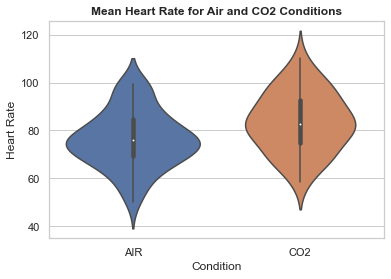

In [21]:
Plots.segment_violin(hr_data_segments, 'PPG_Rate_Mean', 'Mean Heart Rate for Air and CO2 Conditions', 'Condition', 'Heart Rate', 
                    notebook_temp_dir)

In [22]:
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(hr_air_windows, hr_co2_windows, hr_data_windows, 'PPG_Rate_Mean', 2)

Running mixed polynomial regression model independently for air and co2 conditions for: PPG_Rate_Mean
AIR MODEL
                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    PPG_Rate_Mean
No. Observations:     5151       Method:                REML         
No. Groups:           46         Scale:                 6.2328       
Min. group size:      49         Log-Likelihood:        -12213.5597  
Max. group size:      115        Converged:             Yes          
Mean group size:      112.0                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  76.413    1.737 43.981 0.000 73.008 79.818
window_index               -0.020    0.004 -4.799 0.000 -0.028 -0.012
np.power(window_index, 2)   0.000    0.000  5.670 0.000  0.000  

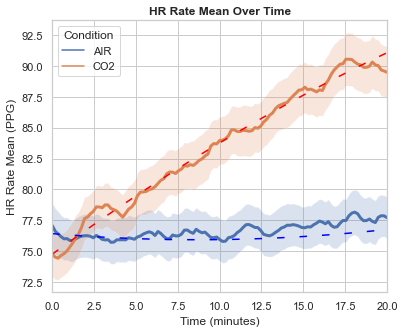

In [23]:
Plots.features_time_series(gas_inhalation_windows, 'PPG_Rate_Mean', 'HR Rate Mean Over Time', 'Time (minutes)', 'HR Rate Mean (PPG)', os.path.join(notebook_temp_dir, "HR_mean_over_time_PPG"), air_prediction_line, co2_prediction_line)

# Pupil Size

In [24]:
# Pupil size
pupil_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|VerboseData.|pupil_)').reset_index(drop=True)
#pupil_data_segments['pupil_size_combined'] = (pupil_data_segments['VerboseData.Left.PupilDiameterMm_mean'] + pupil_data_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2

pupil_air_segments = pupil_data_segments[pupil_data_segments['Condition']=='AIR']
pupil_co2_segments = pupil_data_segments[pupil_data_segments['Condition']=='CO2']

pupil_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|VerboseData.|pupil_)').reset_index(drop=True)
pupil_air_windows = pupil_data_windows[pupil_data_windows['Condition']=='AIR']
pupil_co2_windows = pupil_data_windows[pupil_data_windows['Condition']=='CO2']

In [25]:
# Run Shapiro-Wilk normality tests for both segmented and windowed GSR
Tests.normality_test_sw(pupil_air_segments['pupil_size_combined'], 'AIR')
Tests.normality_test_sw(pupil_co2_segments['pupil_size_combined'], 'CO2')

AIR
Shapiro-Wilk Test - Statistic: 0.9481764435768127
Shapiro-Wilk Test - p-value: 0.03990786895155907
Data for AIR condition is NOT normally distributed.
CO2
Shapiro-Wilk Test - Statistic: 0.977023184299469
Shapiro-Wilk Test - p-value: 0.48974671959877014
Data for CO2 condition is  normally distributed.


ShapiroResult(statistic=0.977023184299469, pvalue=0.48974671959877014)

In [26]:
Tests.paired_t_test(pupil_air_segments['pupil_size_combined'],pupil_co2_segments['pupil_size_combined'])

T-statistic: -1.527
P-value: 0.134
No singificant results found.


(-1.5266319540258766, 0.13385126981008785)

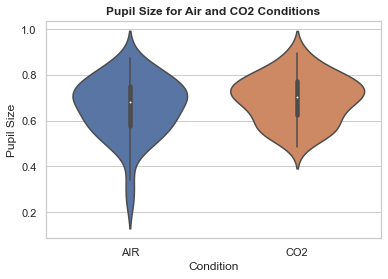

In [27]:
Plots.segment_violin(pupil_data_segments, 'pupil_size_combined', 'Pupil Size for Air and CO2 Conditions', 'Condition', 'Pupil Size', 
                    notebook_temp_dir)

In [28]:
air_prediction_line, co2_prediction_line = Tests.regression_tests_polynomial(pupil_air_windows, pupil_co2_windows, pupil_data_windows, 'pupil_size_combined', 2)

Running mixed polynomial regression model independently for air and co2 conditions for: pupil_size_combined
AIR MODEL
                Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  pupil_size_combined
No. Observations:   5151     Method:              REML               
No. Groups:         46       Scale:               0.0061             
Min. group size:    49       Log-Likelihood:      5672.3679          
Max. group size:    115      Converged:           Yes                
Mean group size:    112.0                                            
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  0.718    0.019  37.061 0.000  0.680  0.756
window_index              -0.002    0.000 -18.160 0.000 -0.003 -0.002
np.power(window_index, 2)  0.000    0.000  15.315 0.000  0

C:\Users\m\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


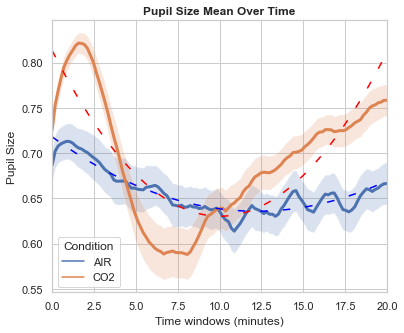

In [29]:
Plots.features_time_series(gas_inhalation_windows, 'pupil_size_combined', 'Pupil Size Mean Over Time', 'Time windows (minutes)', 'Pupil Size', os.path.join(notebook_temp_dir, "Pupil_size"), air_prediction_line, co2_prediction_line)

# EMG Contact

In [30]:
# Pupil size
contact_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Emg/Contact)').reset_index(drop=True)

contact_air_segments = contact_data_segments[contact_data_segments['Condition']=='AIR']
contact_co2_segments = contact_data_segments[contact_data_segments['Condition']=='CO2']

contact_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Emg/Contact)').reset_index(drop=True)
contact_air_windows = contact_data_windows[contact_data_windows['Condition']=='AIR']
contact_co2_windows = contact_data_windows[contact_data_windows['Condition']=='CO2']

In [31]:
# Shapiro-Wilk test for normality


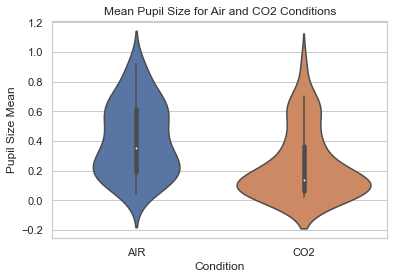

In [32]:
# Create the violin plot
sns.violinplot(x='Condition', y='Emg/Contact[RightOrbicularis]_mean', data=contact_data_segments)

# Customize plot titles and labels
sns.set(style='whitegrid')
plt.title('Mean Pupil Size for Air and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Pupil Size Mean')

# Display the plot
plt.show()

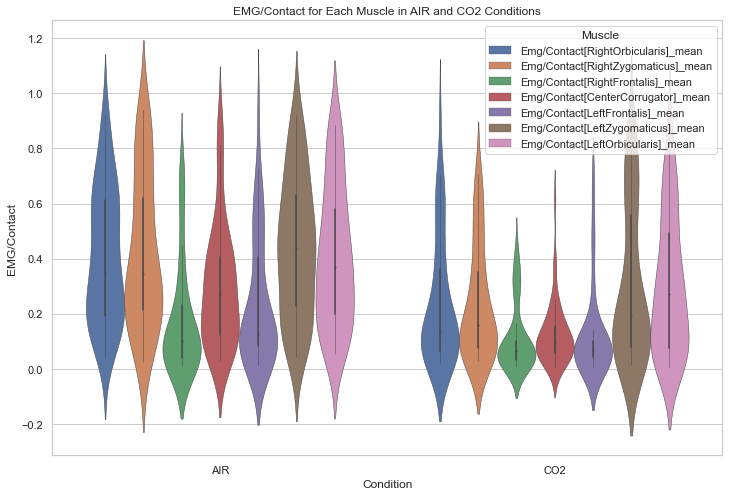

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = contact_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=['Emg/Contact[RightOrbicularis]_mean', 'Emg/Contact[RightZygomaticus]_mean', 'Emg/Contact[RightFrontalis]_mean', 'Emg/Contact[CenterCorrugator]_mean', 'Emg/Contact[LeftFrontalis]_mean', 'Emg/Contact[LeftZygomaticus]_mean', 'Emg/Contact[LeftOrbicularis]_mean'], var_name='Muscle', value_name='Emg_Contact')

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='Emg_Contact', hue='Muscle', data=melted_data, scale='width', linewidth=0.5)


# Customize the plot
plt.title('EMG/Contact for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('EMG/Contact')
plt.legend(title='Muscle')

plt.savefig(os.path.join(notebook_temp_dir, "contact_segments"))
# Show the plot
plt.show()


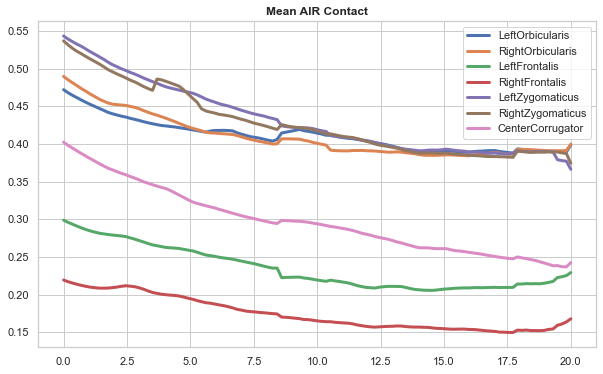

In [34]:
Plots.contact_muscles(contact_air_windows, os.path.join(notebook_temp_dir, "air_contact_windowed"))

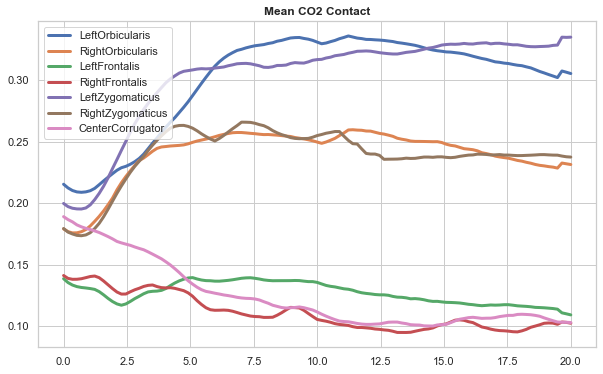

In [35]:
Plots.contact_muscles(contact_co2_windows, os.path.join(notebook_temp_dir, "co2_contact_windowed"))

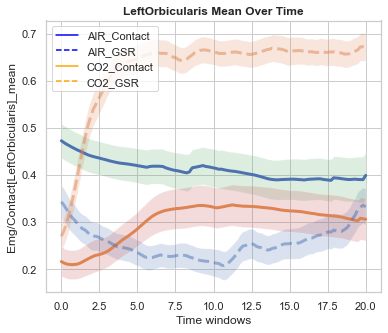

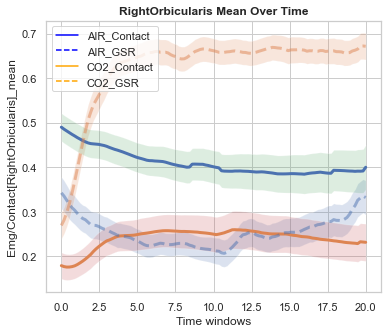

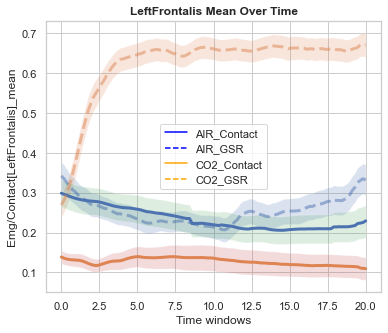

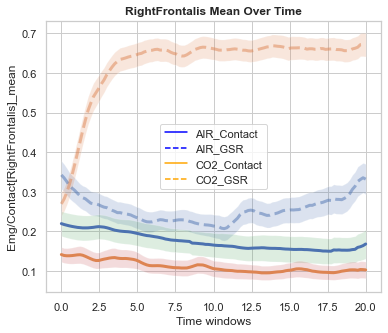

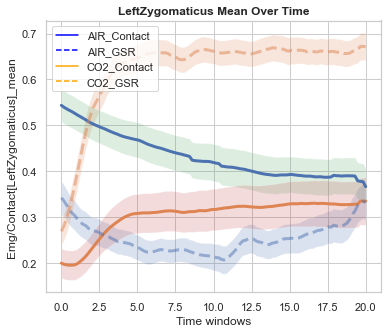

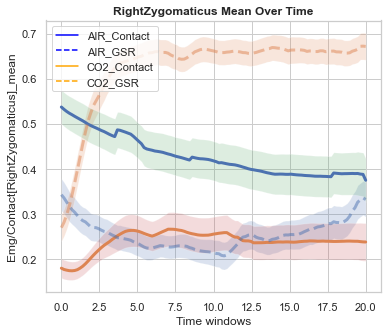

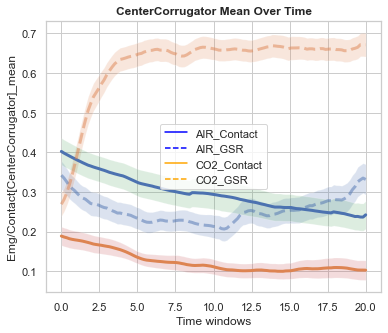

In [36]:
muscles = ['LeftOrbicularis','RightOrbicularis', 'LeftFrontalis', 'RightFrontalis', 'LeftZygomaticus', 'RightZygomaticus', 'CenterCorrugator']

for muscle in muscles:
    muscle_name = f'Emg/Contact[{muscle}]_mean'
    plot_title = f'{muscle} Mean Over Time'
    Plots.contact_gsr_line_plot(gas_inhalation_windows, muscle_name, plot_title, notebook_temp_dir)


# EMG Amplitude

In [37]:
# Pupil size
amp_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Emg/Amplitude)').reset_index(drop=True)

amp_air_segments = amp_data_segments[amp_data_segments['Condition']=='AIR']
amp_co2_segments = amp_data_segments[amp_data_segments['Condition']=='CO2']

amp_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Emg/Amplitude)').reset_index(drop=True)
amp_air_windows = amp_data_windows[amp_data_windows['Condition']=='AIR']
amp_co2_windows = amp_data_windows[amp_data_windows['Condition']=='CO2']

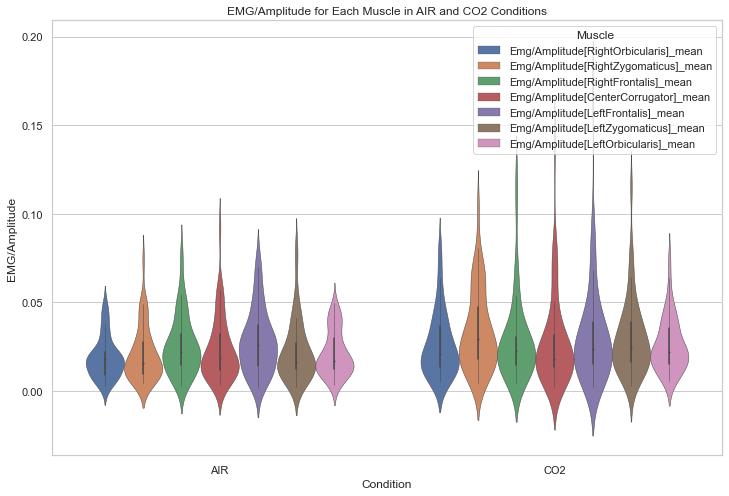

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = amp_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=['Emg/Amplitude[RightOrbicularis]_mean', 'Emg/Amplitude[RightZygomaticus]_mean', 'Emg/Amplitude[RightFrontalis]_mean', 'Emg/Amplitude[CenterCorrugator]_mean', 'Emg/Amplitude[LeftFrontalis]_mean', 'Emg/Amplitude[LeftZygomaticus]_mean', 'Emg/Amplitude[LeftOrbicularis]_mean'], var_name='Muscle', value_name='Emg_Amplitude')

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='Emg_Amplitude', hue='Muscle', data=melted_data, scale='width', linewidth=0.5)


# Customize the plot
plt.title('EMG/Amplitude for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('EMG/Amplitude')
plt.legend(title='Muscle')

plt.savefig(os.path.join(notebook_temp_dir, "amp_segments"))
# Show the plot
plt.show()


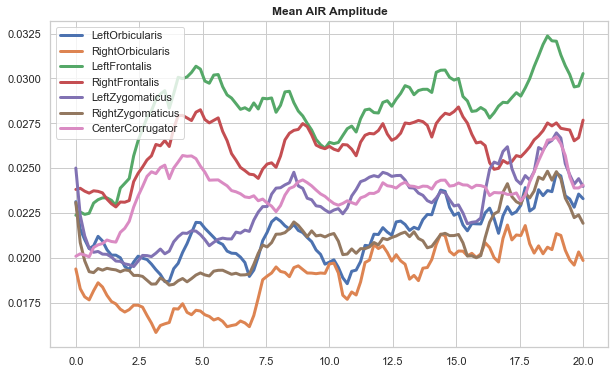

In [97]:
Plots.amp_muscles(amp_air_windows, os.path.join(notebook_temp_dir, "air_amp_windowed"))

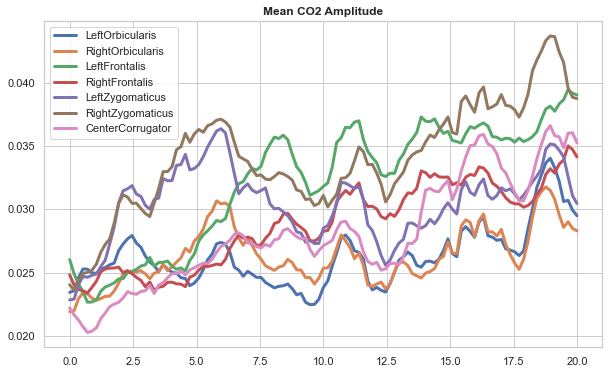

In [96]:
Plots.amp_muscles(amp_co2_windows, os.path.join(notebook_temp_dir, "co2_amp_windowed"))

# Gyro

In [62]:
# Gyroscope
gyro_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Gyroscope)').reset_index(drop=True)

gyro_air_segments = gyro_data_segments[gyro_data_segments['Condition']=='AIR']
gyro_co2_segments = gyro_data_segments[gyro_data_segments['Condition']=='CO2']

gyro_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Gyroscope)').reset_index(drop=True)
gyro_air_windows = gyro_data_windows[gyro_data_windows['Condition']=='AIR']
gyro_co2_windows = gyro_data_windows[gyro_data_windows['Condition']=='CO2']

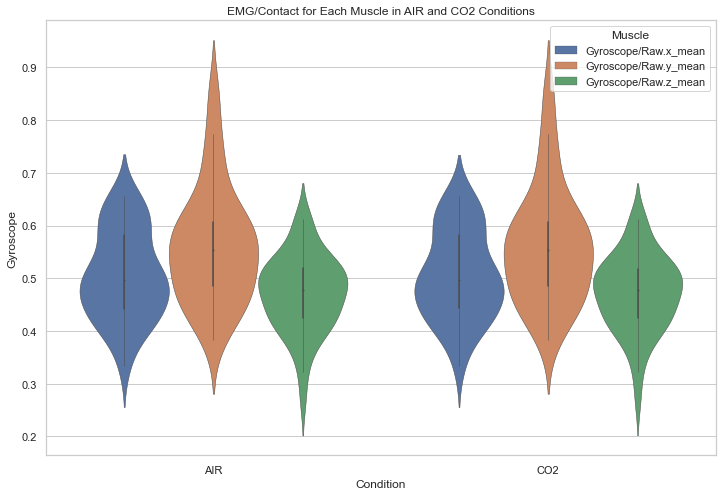

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = gyro_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=['Gyroscope/Raw.x_mean', 'Gyroscope/Raw.y_mean', 'Gyroscope/Raw.z_mean'])

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='value', hue='variable', data=melted_data, scale='width', linewidth=0.5)

# Customize the plot
plt.title('EMG/Contact for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Gyroscope')
plt.legend(title='Muscle')

plt.savefig(os.path.join(notebook_temp_dir, "gyroscope_segments"))
# Show the plot
plt.show()


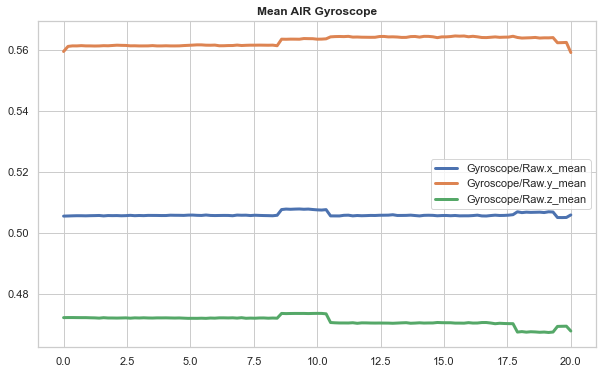

In [102]:
Plots.imu_gyro(gyro_air_windows, os.path.join(notebook_temp_dir, "air_gyro_windowed"))

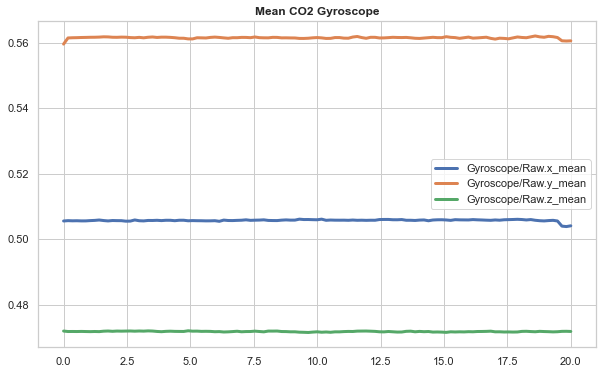

In [103]:
Plots.imu_gyro(gyro_co2_windows, os.path.join(notebook_temp_dir, "co2_gyro_windowed"))

# ACC

In [64]:
# Accelerometer
acc_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Accelerometer)').reset_index(drop=True)

acc_air_segments = acc_data_segments[acc_data_segments['Condition']=='AIR']
acc_co2_segments = acc_data_segments[acc_data_segments['Condition']=='CO2']

acc_data_windows = gas_inhalation_windows.filter(regex=r'^(participant_number|Condition|Segment|window_index|Accelerometer)').reset_index(drop=True)
acc_air_windows = acc_data_windows[acc_data_windows['Condition']=='AIR']
acc_co2_windows = acc_data_windows[acc_data_windows['Condition']=='CO2']

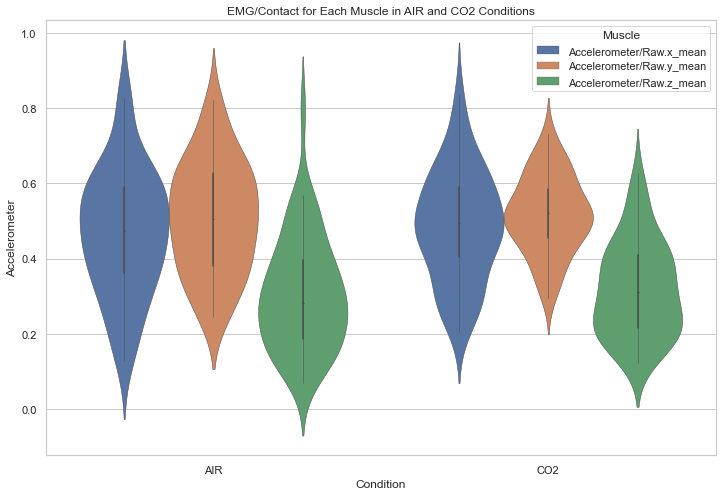

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = acc_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=['Accelerometer/Raw.x_mean', 'Accelerometer/Raw.y_mean', 'Accelerometer/Raw.z_mean'])

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='value', hue='variable', data=melted_data, scale='width', linewidth=0.5)

# Customize the plot
plt.title('EMG/Contact for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Accelerometer')
plt.legend(title='Muscle')

plt.savefig(os.path.join(notebook_temp_dir, "accelerometer_segments"))
# Show the plot
plt.show()


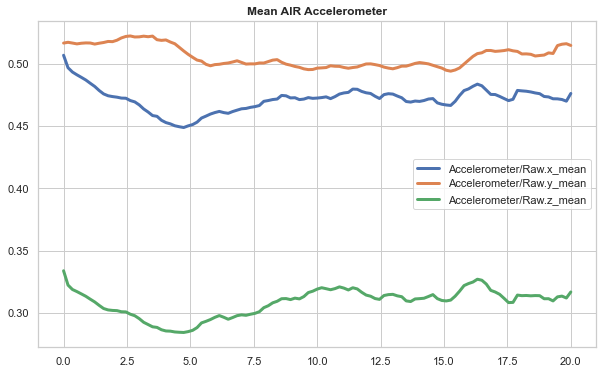

In [109]:
Plots.imu_acc(acc_air_windows, os.path.join(notebook_temp_dir, "air_acc_windowed"))

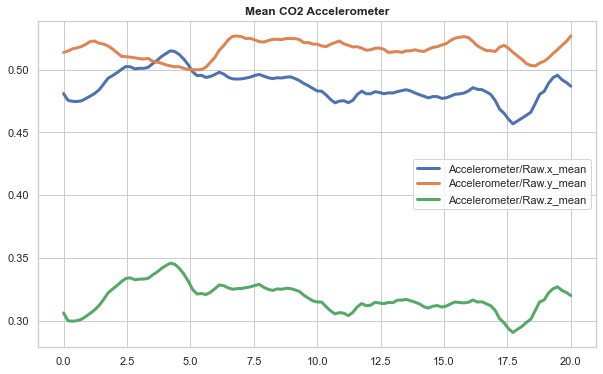

In [111]:
Plots.imu_acc(acc_co2_windows, os.path.join(notebook_temp_dir, "co2_acc_windowed"))

# Correlation Matrix

D:\co2-study\utils\Tests.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


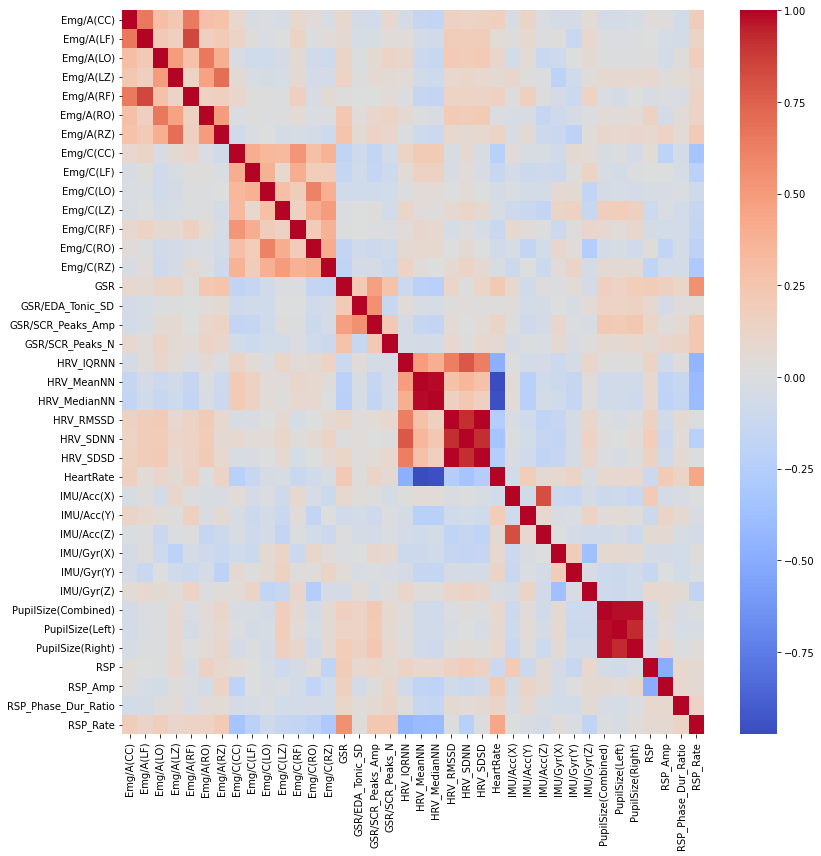

In [37]:
correlation_data = Tests.correlation_test(gas_inhalation_windows)
Plots.correlation_heatmap(correlation_data, os.path.join(notebook_temp_dir, "correlation_heatmap"))